# Tvorba rozhodovacího stromu

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.gridspec as gridspec
from scipy.stats import mode
import sys


# PATH TRICK
sys.path.append('..')
from visualize.read_positions import read_positions


sns.set_style("darkgrid")

palette = sns.color_palette("hls", 5)
sns.set_palette(palette)



In [2]:
df = read_positions(label_dir='../../data_all/labels', output_csv='positions.csv')
#dates_to_exclude = [pd.to_datetime('2024-01-21').date(), pd.to_datetime('2024-01-22').date(), pd.to_datetime('2024-01-23').date()]
#df = df[~df['Date'].dt.date.isin(dates_to_exclude)]
df.head()

,Camera,Date,X_center,Y_center,Width,Height
0,1,2024-02-21 04:00:00,0.747396,0.2825,0.223958,0.361
1,1,2024-02-21 04:00:00,0.327604,0.8415,0.206250,0.301
2,7,2024-02-23 00:30:00,0.459896,0.7475,0.236458,0.469
3,2,2024-02-09 15:30:00,0.835677,0.5505,0.207813,0.405
4,2,2024-02-09 15:30:00,0.644531,0.3980,0.180729,0.408


Na základě analýzy dat vytvoříme data, podle kterých natrénujeme náš model.

Pro každý konkrétní čas budeme chtít predikovat kameru, na které bylo nejvíc slonů, viz `BestCamera`.

Predikovat budeme na základě dne času a dne v týdnu.

In [3]:
def get_random_mode(series):
    m = mode(series)
    if isinstance(m.mode, np.ndarray) and len(m.mode) > 1:
        return np.random.choice(m.mode)
    else:
        return m.mode

grouped = df.groupby('Date')['Camera'].agg(lambda x: get_random_mode(x)).reset_index()

grouped['DayOfWeek'] = grouped['Date'].dt.dayofweek

# Convert time
grouped['DecimalTime'] = grouped['Date'].dt.hour + grouped['Date'].dt.minute / 60.0
camera_presence = df.groupby('Date')['Camera'].apply(lambda x: x.unique().tolist()).reset_index()
camera_presence

X = grouped[['DecimalTime', 'DayOfWeek']]
y = pd.DataFrame(grouped['Camera'])
y.rename(columns={"Camera": "BestCamera"}, inplace=True)
y['CameraPresence'] = camera_presence['Camera']


Rozdělení dat na trénovací, validační a testovací v poměru 60:20:20

In [4]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=36)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=49)

y_test, y_test_all = y_test['BestCamera'], y_test
y_train, y_train_all = y_train['BestCamera'], y_train
y_val, y_val_all = y_val['BestCamera'], y_val

Vyladíme všechny možné paramatry v rozhodovacím stromě.

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}
Best Validation Accuracy: 0.6396
Test Set Accuracy: 0.6229


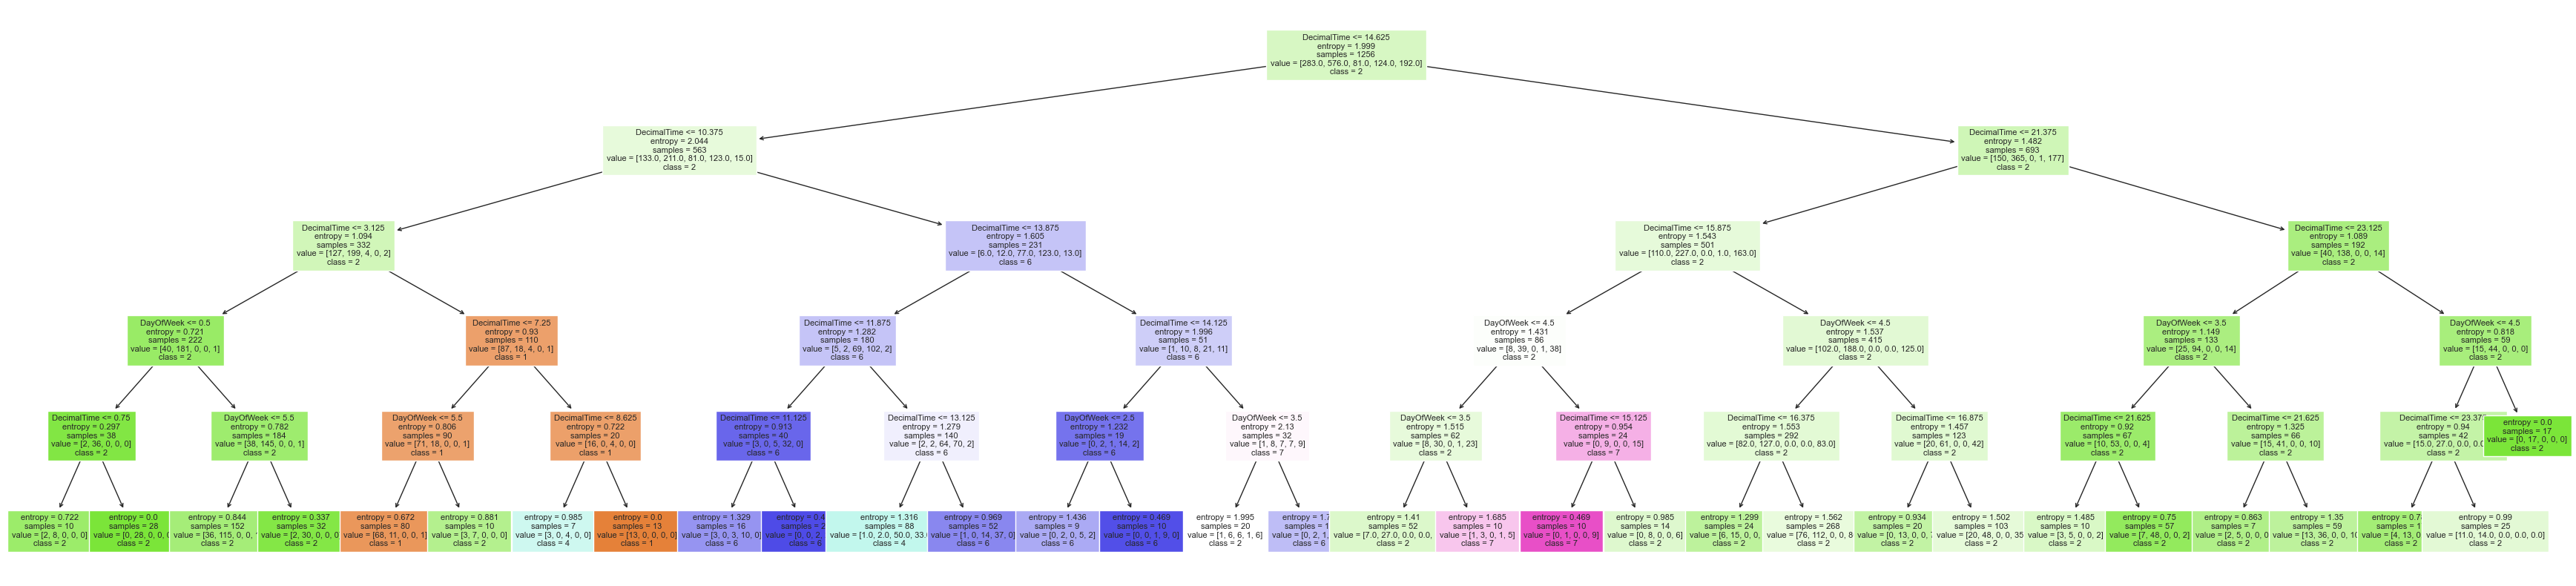

In [5]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import numpy as np

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11)
}

grid = ParameterGrid(param_grid)


best_params = None
best_accuracy = 0

for params in grid:
    clf = DecisionTreeClassifier(random_state=42, **params)
    clf.fit(X_train, y_train)
    y_pred_val = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred_val)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

clf_best = DecisionTreeClassifier(random_state=42, **best_params)
clf_best.fit(X_train, y_train)

y_pred_test = clf_best.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Set Accuracy: {accuracy_test:.4f}")

plt.figure(figsize=(35, 8))
class_names = sorted(clf_best.classes_.astype(str))
plot_tree(clf_best, feature_names=['DecimalTime', 'DayOfWeek'], class_names=class_names, filled=True, fontsize=8)
plt.tight_layout()
plt.show()


Výše uvedená přesnost na validační množině se nám nemusí zdát příliš dobrá. Můžeme však zkusit zda v predikované kameře bylo v dané chvíli aspoň jeden slon.

In [6]:
def accuracy_all(y_test_all, y_pred_test):
    """
    Calculates the accuracy of predictions based on the presence of predicted camera in a test_set, not necessarily the one with most Elephants
    """
    correct = 0
    for idx in range(len(y_test_all)):
        pred = y_pred_test[idx]
        if pred in y_test_all.iloc[idx]['CameraPresence']:
            correct += 1
    return correct/len(y_test_all)
accuracy_test_all = accuracy_all(y_test_all, y_pred_test)
print(f"Adjusted Test Set Accuracy: {accuracy_test_all:.4f}")

Adjusted Test Set Accuracy: 0.9308


Tedy můžeme očekovát, že náš model v 93 % případů bude predikovat kameru, kde je aspoň jeden slon a návštěvník nebude ochuzen.

In [7]:
from joblib import dump
dump(clf_best, 'decision_tree.joblib')


['decision_tree.joblib']